<a href="https://colab.research.google.com/github/ujanichakma/AI_LAB_4-1_2025/blob/main/AI_final_assignment/AI_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
(10000, 96, 96, 3)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Partial FT Training...
Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.7286 - loss: 0.5335 - val_accuracy: 0.8120 - val_loss: 0.4149
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8404 - loss: 0.3653 - val_accuracy: 0.8285 - val_loss: 0.3808
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8234 - loss: 0.3748
Partial Test: [0.3733711540699005, 0.8274999856948853]
Whole FT Training...
Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8986 - loss: 0.2420 - val_accuracy: 0.8560 - val_loss: 0.3510
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - accuracy: 0.9493 - loss: 0.1486 - val_accuracy: 0.8615 - val_loss: 0.3709
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8641 - loss: 0.3521
Whole Test: [0.35271528363227844, 0.862999

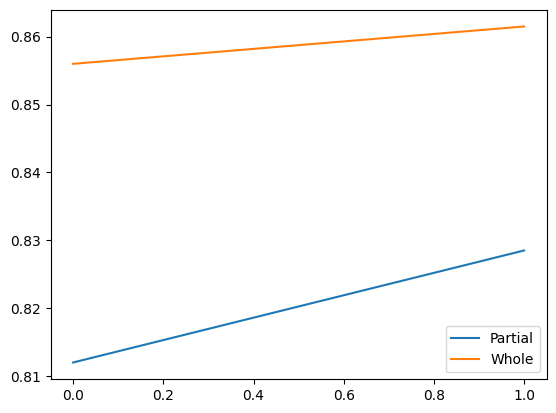

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

print("GPU:", tf.config.list_physical_devices('GPU'))

# ---------------- LOAD DATA ----------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

CAT, DOG = 3, 5

def filter_cat_dog(x, y):
    mask = np.where((y == CAT) | (y == DOG))[0]
    x = x[mask]
    y = y[mask]
    y = (y == DOG).astype("float32")
    return x, y

x_train, y_train = filter_cat_dog(x_train, y_train)
x_test, y_test   = filter_cat_dog(x_test, y_test)

# normalize
x_train = x_train / 255.0
x_test  = x_test / 255.0

# resize (light)
x_train = tf.image.resize(x_train, (96,96))
x_test  = tf.image.resize(x_test, (96,96))

print(x_train.shape)

# ---------------- MODEL ----------------
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(96,96,3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, output)

# ================= PARTIAL FT =================
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Partial FT Training...")
hist1 = model.fit(x_train, y_train,
                  validation_split=0.2,
                  epochs=2,
                  batch_size=16)

print("Partial Test:", model.evaluate(x_test, y_test))

# ================= WHOLE FT =================
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Whole FT Training...")
hist2 = model.fit(x_train, y_train,
                  validation_split=0.2,
                  epochs=2,
                  batch_size=16)

print("Whole Test:", model.evaluate(x_test, y_test))

# ---------------- PLOT ----------------
plt.plot(hist1.history['val_accuracy'], label="Partial")
plt.plot(hist2.history['val_accuracy'], label="Whole")
plt.legend()
plt.show()